# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Data](#5.4_Load_Data)
  * [5.5 Train/Test Split](#5.5_Train/Test_Split)
    * [5.6 Models](#5.6_Models)
    * [5.6.1 Define required functions to fit models and evaluate their performances](#5.6.1_Define_required_functions_to_fit_models_and_evaluate_their_performances)
    * [5.6.2 Models with all features](#5.6.2_Models_with_all_features)
    * [5.6.3 Models with selected features](#5.6.3_Models_with_selected_features)
    * [5.6.4 Final Model Selection](#5.6.4_Final_Model_Selection)    
  * [5.7 Feature importance](#5.7_Feature_importance)    
  * [5.8 Save best model object](#5.8_Save_best_model_object)
  * [5.9 Summary](#5.9_Summary)
 


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now examine some models to examine their performances.

## 5.3 Imports<a id='5.3_Imports'></a>

In [118]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import missingno as msno
import shap


import datetime

from library.sb_utils import save_file

## 5.4 Load Data<a id='5.4_Load_Data'></a>

The dataset consists of all features and also the dataset contains some features are loaded.

In [119]:
ecg_data_selected = pd.read_csv('../data/ecg_data_step3_features_uncorrelated85.csv')
ecg_data_selected.head()


,t0,t1,t6,t7,t139,Target
0,-0.112522,-2.827204,-2.181408,-1.818287,0.193137,1.0
1,-1.100878,-3.996840,-1.566126,-0.992258,-1.436250,1.0
2,-0.567088,-2.593450,-1.742940,-1.490658,-0.421797,1.0
3,0.490473,-1.914407,-2.993280,-1.671131,-0.383564,1.0
4,0.800232,-0.874252,-2.534510,-1.783423,1.421456,1.0


In [120]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features.csv')
ecg_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## 5.5 Train/Test Split<a id='5.5_Train/Test_Split'></a>

In [121]:
# Define a function to split the dataset into train and test parts
def Split_Dataset_Train_Test(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Target'), 
                                                        data.Target, test_size=0.2,
                                                        stratify= data.Target,random_state=47)

    return  X_train, X_test, y_train, y_test

In [122]:
X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(ecg_data)

In [123]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((3998, 140), (3998,), (1000, 140), (1000,))

## 5.6 Models<a id='5.6_Models'></a>

### 5.6.1 Define required functions to fit models and evaluate their performances<a id='5.6.1_Define_required_functions_to_fit_models_and_evaluate_their_performances'></a>

In [124]:
# Show model's performance

def model_results(model, y_train, y_tr_pred, y_test, y_te_pred, show_training_result=True ):

    print( model)
    print('-------------------------------------')
    if show_training_result:
        print("Classification Report for Training Data")
        print(classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']))
    print('-------------------------------------')
    print("Classification Report for Test Data")
    print(classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']))


In [125]:
# Plot Model's ROC

def plot_ROC(model,X, y, title_method ):
    
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [126]:
#  train and test a model 

def train_test_model(model, grid_params, X_train, y_train, X_test, y_test, model_name):
    pipe = make_pipeline(
    StandardScaler(),
    model
    )

    rskf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=True)
    model_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=rskf, n_jobs=-1)
    # print(model_grid_cv.get_params().keys())
    # print(model_grid_cv)
    model_grid_cv.fit(X_train, y_train)
    
    y_tr_pred = model_grid_cv.predict(X_train)
    y_te_pred = model_grid_cv.predict(X_test)
    


    # if model_name in ['Random Forest', 'K_Neighbors', 'Logistic Regression'] :
    show_training_result = False
    # else:
        # show_training_result= True
    model_results(model_name, y_train, y_tr_pred, y_test, y_te_pred,show_training_result )  
    plot_ROC(model_grid_cv, X_test, y_test, model_name)

    row_model = {'model_name':model_name, 'Accuracy on training data':accuracy_score(y_tr_pred, y_train), 'Accuracy on test data':accuracy_score(y_te_pred, y_test),
'Precision score on training data':precision_score(y_train, y_tr_pred,  pos_label=0), 'Precision score  on test data':precision_score( y_test, y_te_pred,  pos_label=0), 
'Recall score on training data':recall_score(y_train, y_tr_pred, pos_label=1),  'Recall score  on test data':recall_score( y_test, y_te_pred, pos_label=1), 
'F1 score on training data':f1_score(y_train, y_tr_pred, pos_label =0 ), 'F1 score  on test data':f1_score( y_test, y_te_pred, pos_label=1), 
'Classification Report for Training Data':classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']), 
'Classification Report for Test Data':classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']), 
'best_params_':model_grid_cv.best_params_

    }
    return(row_model) 



Six machine learning algorithms for classification problems, including: logistic regression, random forest, KNeighborsClassifier, XGBClassifier, MLPClassifier, and SVM  are applied on the train dataset. Then, the performances of these models are evaluated using metrics Accuracy, Precision, Recall, and F1 score and plotting Receiver-Operator Curve (ROC Curve) and calculating Area Under the Curve (AUC).

In [127]:
def apply_evaluate_models(data):
    X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(data)

    # define 6 models LogisticRegression, RandomForestClassifier, KNeighborsClassifier, XGBClassifier, MLPClassifier, and SVM and their parameters
    params = [
    {'classifier' : [LogisticRegression(random_state=42)], 'model_name' : ['Logistic Regression'],
    'param_grid': { 'logisticregression__penalty' : ['l1', 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
    {'classifier' : [RandomForestClassifier(random_state=42)], 'model_name' : ['Random Forest'],
    'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
    {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
    'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}},
    {'classifier' : [XGBClassifier(random_state=42)], 'model_name' : ['XGBoost'],
    'param_grid': { 'xgbclassifier__learning_rate':  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'xgbclassifier__n_estimators': [100, 200, 300, 400, 500], 'xgbclassifier__gamma' : [0.5, 1.5]}},
    {'classifier' : [MLPClassifier(random_state=42)], 'model_name' : ['Non Deep NN'],
    'param_grid': { 'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)], 'mlpclassifier__activation': ['tanh', 'relu'], 'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05], 'mlpclassifier__learning_rate': ['constant','adaptive'] }}, 
    {'classifier' : [SVC(random_state=42, probability=True)], 'model_name' : ['SVM'],
    'param_grid': { 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'svc__kernel': ['rbf'] }}

]


    # define a dataframe to save performance metrics
    df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on test data',
    'Precision score on training data', 'Precision score  on test data', 
    'Recall score on training data', 'Recall score  on test data', 
    'F1 score on training data', 'F1 score  on test data', 
    'Classification Report for Training Data', 
    'Classification Report for Test Data', 
    'best_params_'])

    # train and test models
    for model_params in params:
        model = model_params['classifier'][0]
        param_grid = model_params['param_grid']
        model_name = model_params['model_name'][0]
        result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
        
        df_results.loc[len(df_results.index)] = result

    return df_results


### 5.6.2 Models using all features<a id='5.6.2_Models_with_all_features'></a>

Logistic Regression
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.98      0.98       416
      NORMAL       0.98      0.99      0.99       584

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



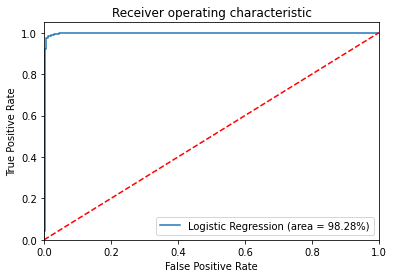

Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.98      0.99       416
      NORMAL       0.99      1.00      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



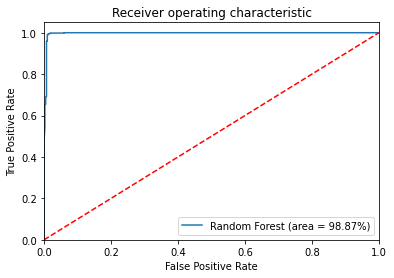

K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.99      0.99       416
      NORMAL       0.99      0.99      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



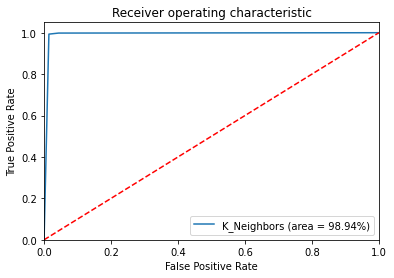

XGBoost
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99       416
      NORMAL       0.99      1.00      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



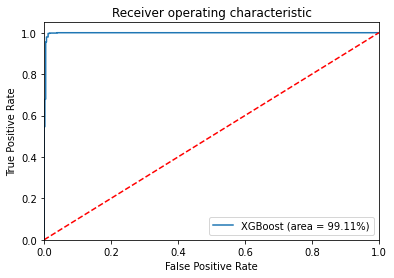

Non Deep NN
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99       416
      NORMAL       0.99      1.00      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



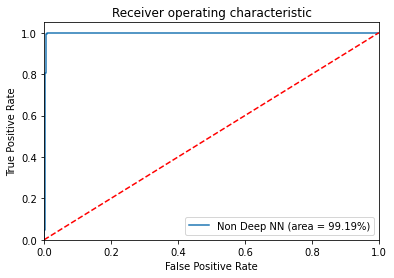

SVM
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.98      0.99       416
      NORMAL       0.99      0.99      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



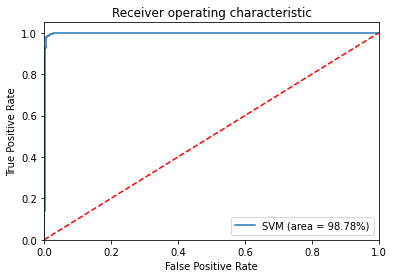

In [128]:
df_results = apply_evaluate_models(ecg_data)

Models performances

In [129]:
pd.set_option('display.max_colwidth', 3000)
df_results.iloc[:, [0, 2, 4,6,8,11]]

,model_name,Accuracy on test data,Precision score on test data,Recall score on test data,F1 score on test data,best_params_
0,Logistic Regression,0.984,0.985437,0.989726,0.986348,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}"
1,Random Forest,0.990,0.995122,0.996575,0.991482,"{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 10}"
2,K_Neighbors,0.990,0.990338,0.993151,0.991453,"{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}"
3,XGBoost,0.992,0.995146,0.996575,0.993174,"{'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100}"
4,Non Deep NN,0.993,0.997567,0.998288,0.994032,"{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (20,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}"
5,SVM,0.989,0.992701,0.994863,0.990622,"{'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}"


### 5.6.3 Models with selected features<a id='5.6.3_Models_with_selected_features'></a>

Logistic Regression
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.88      0.90       416
      NORMAL       0.92      0.94      0.93       584

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.92      0.92      0.92      1000



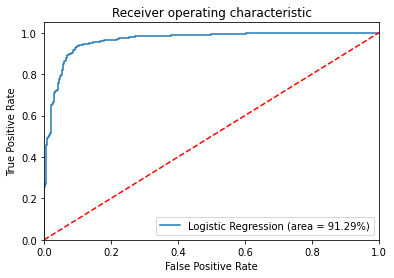

Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.92      0.93       416
      NORMAL       0.94      0.96      0.95       584

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



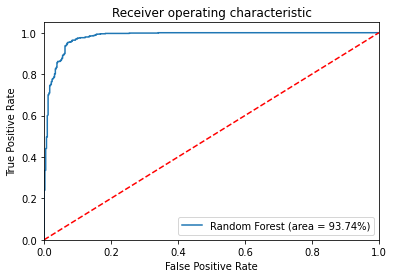

K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.94      0.94       416
      NORMAL       0.96      0.95      0.95       584

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



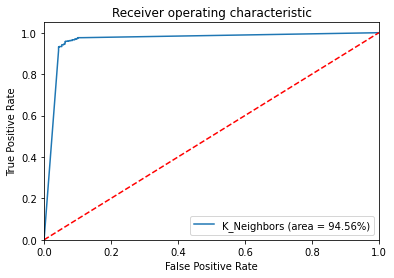

XGBoost
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.96      0.92      0.94       416
      NORMAL       0.95      0.98      0.96       584

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



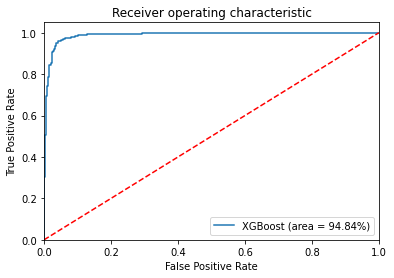

Non Deep NN
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.98      0.94      0.96       416
      NORMAL       0.96      0.98      0.97       584

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


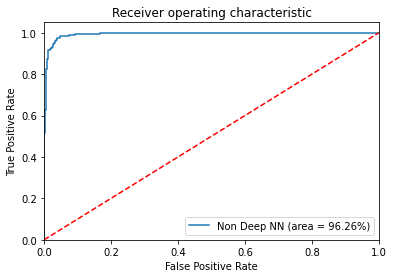

SVM
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.97      0.95      0.96       416
      NORMAL       0.96      0.98      0.97       584

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



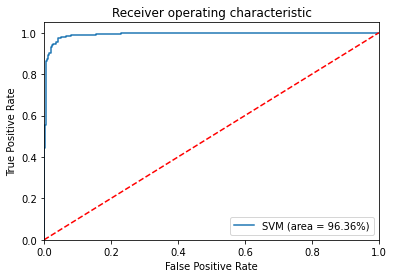

In [130]:
df_results = apply_evaluate_models(ecg_data_selected)

Models performances

In [131]:
pd.set_option('display.max_colwidth', 3000)
df_results.iloc[:, [0, 2, 4,6,8,11]]

,model_name,Accuracy on test data,Precision score on test data,Recall score on test data,F1 score on test data,best_params_
0,Logistic Regression,0.918,0.917500,0.943493,0.930743,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}"
1,Random Forest,0.941,0.940741,0.958904,0.949958,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 10}"
2,K_Neighbors,0.947,0.935252,0.953767,0.954584,"{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'distance'}"
3,XGBoost,0.953,0.964736,0.976027,0.960404,"{'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200}"
4,Non Deep NN,0.966,0.975124,0.982877,0.971235,"{'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (10, 30, 10), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}"
5,SVM,0.966,0.968137,0.977740,0.971088,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}"


We have now fitted several models using machine learning and we are ready to compare performance of the final models on test dataset. The list of all models, their performance metrics can be found above.  
Accuracy works best if false positives and false negatives have similar cost. However, in this case, the cost of false positives and false negatives are very different and F1 score takes both false positives and false negatives into account, it’s better to look at F1 score. 


### 5.6.4 Final Model Selection<a id='5.6.4_Final_Model_Selectio'></a>


 

Base on F1 score metric, the Non Deep NN has the most value among all models above, so it is considered as the best model for this case.


## 5.7 Feature importance<a id='5.7_Feature_importance'></a>

In [132]:
def find_feature_importance(X, y, model_name, model):
    
    if model_name == 'LogisticRegression':
        m = model
        m.fit(X / np.std(X, 0), y)
        print('Feature Importance using LogisticRegression algorithm :',m.coef_)
        


    elif model_name == 'RandomForestClassifier':
        feature_names = [f"feature {i}" for i in range(X.shape[1])]
        forest = model
        forest.fit(X, y)
        
        importances = forest.feature_importances_
        feature_count = 20
        # print(importances[:feature_count])
        # print(feature_names)
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

        forest_importances = pd.Series(importances[:feature_count], index=feature_names[:feature_count])

        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std[:feature_count], ax=ax)
        ax.set_title("Feature importances using RandomForest algorithm")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
    elif model_name == 'XGBClassifier':
        model.fit(X, y)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, X)
        ax.set_title("Feature importances using XGBClassifier algorithm")

        

Feature importance base on a Subet of Test Dataset

Features:  ['t0' 't1' 't6' 't7' 't139']


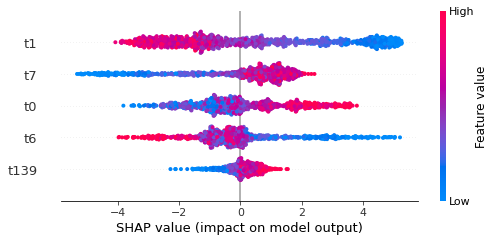

In [133]:
X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(ecg_data_selected)
X, y = X_test,  y_test
print('Features: ', X_test.columns.values)
# find_feature_importance(X, y,'LogisticRegression', LogisticRegression(C=0.1, penalty='l2', solver='liblinear'))
# find_feature_importance(X, y,'RandomForestClassifier', RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=10))
find_feature_importance(X, y,'XGBClassifier', XGBClassifier(gamma='0.5', learning_rate=0.2, n_estimators=100))

In SHAP approach, the features ranked from top to bottom by their mean absolute SHAP values for the test dataset. 

As it can be seen above, the higher values of features t1 and t6 have negative SHAP values and lower values of these features have positive SHAP values which indicate higher t1 and t6 lead to 'normal'(class 1) predictions. However, the higher values of t7, t10, ans t139 lead to 'anormal'(class 0) prediction. 

Feature importance base on the all test dataset

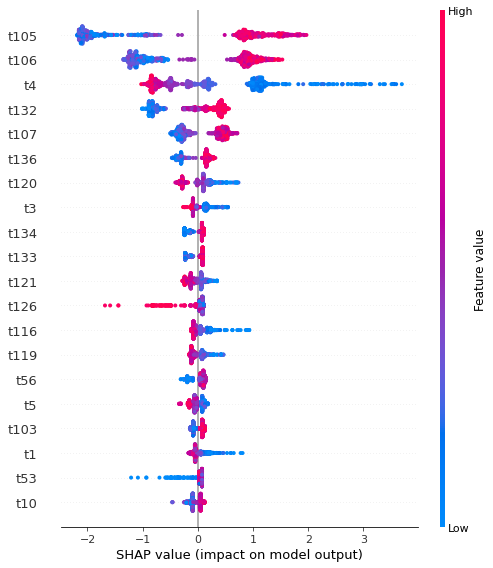

In [134]:
X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(ecg_data)
X, y = X_test,  y_test
# print('Features: ', X_test.columns.values)
# find_feature_importance(X, y,'LogisticRegression', LogisticRegression(C=0.1, penalty='l2', solver='liblinear'))
# find_feature_importance(X, y,'RandomForestClassifier', RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=10))
find_feature_importance(X, y,'XGBClassifier', XGBClassifier(gamma='0.5', learning_rate=0.2, n_estimators=100))

As it can be seen, the higher values of features t105, t106, t132, t107, t136, t134, t133, t56, t103, t53, and t10 have positive SHAP values and lower values of these features have negative SHAP values which indicate higher t105, t106, t132, t107, t136, t134, t133, t56, t103, t53, and t10 lead to 'normal'(class 1) predictions. 
However, the higher values of features t4, t3, t120, t121, 126, t119, t116, t5, and t1 have negative SHAP values which leads to 'abnormal' (class 0) prediction. 


The higher values of features t4, t120, t3, t121, t126, t116, t119, t5, and t1 have negative SHAP values and lower values of these features have positive SHAP values which indicate higher values of these features lead to class 0 predictions. 

## 5.8 Save best model object<a id='5.8_Save_best_model_object'></a>

In [142]:
# Extract the best model parameters
best_params_ = df_results.loc[df_results['model_name']== 'Non Deep NN']['best_params_']
best_params_

4    {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (10, 30, 10), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}
Name: best_params_, dtype: object

In [145]:
best_model = MLPClassifier(best_params_)
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [147]:
# save the model
modelpath = '../models'
save_file(best_model, 'anomalydetection_model.pkl', modelpath)

Writing file.  "../models\anomalydetection_model.pkl"


## 5.9 Summary<a id='5.9_Summary'></a>

In this notebook, a pipeline is built of steps scaling, and models to move faster but with confidence. Six machine learning algorithms including: logistic regression, random forest, KNeighborsClassifier, XGBClassifier, MLPClassifier, and SVM are selected to applied on the train part. In order to have best performance, cross-validation and GridSearchCV are used for estimating models performance and hyperparameters tunning. The performances of these models are evaluated using metrics Accuracy, Precision, Recall, and F1 score and plotting Receiver-Operator Curve (ROC Curve). Among metrics, accuracy works best if false positives and false negatives have similar cost. However, in this case, the cost of false positives and false negatives are very different and as F1 score takes both false positives and false negatives into account, it’s better to look at F1 score. 
Now is time to select the final model with best parameters to have best performance. Base on F1 score metric, the Non Deep NN has the highest value among all models above, so it is considered as the best model for this case. In addition, the important features are identified base on a test dataset with two different set of features (whole features and a subset of whole features) using XGBoost model and SHAP method. Hoever, the result shows most important features in these two dataset are not similar.
